In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


In [ ]:
!pip install deepchem
import deepchem as dc

     |████████████████████████████████| 608 kB 5.0 MB/s 
     |████████████████████████████████| 22.5 MB 7.0 MB/s 


In [ ]:
import torch
pytorch_version = "torch-" + torch.__version__ + ".html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 2.6 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 2.9 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 2.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 2.5 MB/s 
     |████████████████████████████████| 407 kB 5.1 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=a46966c992418b2a322ee854eadb72ec52571212687033276383eb8795b5311e
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [ ]:
import pandas as pd
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import rdmolops, Draw
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from deepchem.feat.base_classes import MolecularFeaturizer

In [ ]:
class MoleculeDataset(Dataset):
  def __init__(self, root, transform=None, pre_transform=None):
    super(MoleculeDataset, self).__init__(root, transform, pre_transform)

  @property
  def raw_file_names(self):
    return 'BBBP_P.csv'

  @property
  def processed_file_names(self):
    return 'not_implemented.pt'

  def download(self):
    pass

  def process(self):
    self.data = pd.read_csv(self.raw_paths[0])
    #self.data.drop(labels=['num', 'name'], axis=1, inplace=True)
    #self.corrupted_molecules = 0
    self.count = 0
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
      try: #stan zero
        molecule = Chem.MolFromSmiles(mol["smiles"])
      except:
        #print(index)
        #self.corrupted_molecules += 1
        continue
      if molecule is not None:

        
        # node_features = self._get_node_features(molecule)
        # edge_features = self._get_edge_features(molecule)
        # edge_index = self._get_adjecency_info(molecule)
        
        out = featurizer.featurize(mol["smiles"])
        node_features = torch.tensor(out[0].node_features, dtype=torch.float)
        edge_features = torch.tensor(out[0].edge_features, dtype=torch.float)
        edge_index = torch.tensor(out[0].edge_index, dtype=torch.long)

        label = self._get_labels(mol['p_np'])

        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=label, smiles=mol['smiles'])
        #torch.save(data, os.path.join(self.processed_dir, f'data_{index-self.corrupted_molecules}.pt'))
        torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))
      else:
        self.count += 1
      # except:
      #   print(index)
      #   self.corrupted_molecules += 1
      #   pass
    # print('Number of corrupted molecules: ', self.corrupted_molecules)
    print("End:", self.count)

  def _get_node_features(self, molecule):

    all_node_features = []

    for atom in molecule.GetAtoms():
      node_fts = []
      node_fts.append(atom.GetAtomicNum()) #atomic number
      node_fts.append(atom.GetFormalCharge()) #formal charge
      node_fts.append(atom.GetChiralTag()) #chiral tag
      node_fts.append(atom.GetIsAromatic()) #is aromatic
      all_node_features.append(node_fts)

    all_node_features = np.asarray(all_node_features)
    return torch.tensor(all_node_features, dtype=torch.float)


  def _get_edge_features(self, molecule):

    all_edge_features = []

    for bond in molecule.GetBonds():
      edge_fts = []
      edge_fts.append(bond.GetBondTypeAsDouble()) #bond type as double
      edge_fts.append(bond.GetStereo()) #bond stereo
      all_edge_features.append(edge_fts)

    all_edge_features = np.asarray(all_edge_features)
    return torch.tensor(all_edge_features, dtype=torch.float)

  def _get_adjecency_info(self, molecule):
    edge_indices = []
    for bond in molecule.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]

    edge_indices = torch.tensor(edge_indices)
    edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    return edge_indices

  def _get_labels(self, label):
    label = np.asarray([[label]])
    res = torch.tensor(label, dtype=torch.int64)
    return res

  def len(self):
    return self.data.shape[0]

  def get(self, idx):
    data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
    return data

In [ ]:
data_folder = 'drive/MyDrive/Graph_Data/'
data = MoleculeDataset(root=data_folder)

Processing...
100%|██████████| 2039/2039 [00:43<00:00, 47.06it/s]

End: 0



Done!


In [ ]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class '__main__.MoleculeDataset'>
Dataset features:  30
Dataset length:  <bound method MoleculeDataset.len of MoleculeDataset(2039)>
Dataset sample:  Data(x=[20, 30], edge_index=[2, 40], edge_attr=[40, 11], y=[1, 1], smiles='[Cl].CC(C)NCC(O)COc1cccc2ccccc12')
Sample  nodes:  20
Sample  edges:  40


In [ ]:
print('Edge indexes in coo format: ', data[0].edge_index.t()) #edge indexes in coo format
print('\n Node features: ', data[0].x) #node features matrix
print('\n Edge features: ', data[0].edge_attr) #edge features matrix
print('\n Label: ', data[0].y) # label

Edge indexes in coo format:  tensor([[ 1,  3],
        [ 3,  1],
        [ 3,  7],
        [ 7,  3],
        [ 3, 16],
        [16,  3],
        [16, 12],
        [12, 16],
        [12, 17],
        [17, 12],
        [17, 11],
        [11, 17],
        [17, 15],
        [15, 17],
        [15, 13],
        [13, 15],
        [13, 18],
        [18, 13],
        [18,  5],
        [ 5, 18],
        [ 5,  8],
        [ 8,  5],
        [ 8,  4],
        [ 4,  8],
        [ 4,  9],
        [ 9,  4],
        [ 9, 10],
        [10,  9],
        [10, 14],
        [14, 10],
        [14, 19],
        [19, 14],
        [19,  6],
        [ 6, 19],
        [ 6,  2],
        [ 2,  6],
        [ 2, 18],
        [18,  2],
        [ 2,  9],
        [ 9,  2]])

 Node features:  tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0.,

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 128

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        self.linear1 = Linear(embedding_size*2, embedding_size)
        self.linear2 = Linear(embedding_size, 1)

    def forward(self, x, edge_index, batch):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch), 
                            gap(hidden, batch)], dim=1)

        # Output 
        hidden = self.linear1(hidden).relu()
        hidden = F.dropout(hidden, p=0.2, training=self.training)
        hidden = self.linear2(hidden)

        return hidden

In [ ]:
model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(30, 128)
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  86529


In [ ]:
from torch_geometric.data import DataLoader
# import warning
# warnings.filterwarnings("ignore")

In [ ]:
# Root mean squared error
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

In [ ]:
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# #Data split
train_percent = 0.8
validate_percent = 0.1
train_index = int(train_percent*len(data))
valid_index = int(validate_percent*len(data))

data = data.shuffle()
train_dataset = data[:train_index]
valid_dataset = data[train_index:(train_index+valid_index)]
test_dataset = data[(train_index+valid_index):]

print('Length of train dataset: ', len(train_dataset))
print('Length of validation dataset: ', len(valid_dataset))
print('Length of test dataset: ', len(test_dataset))

Length of train dataset:  1631
Length of validation dataset:  203
Length of test dataset:  205


In [ ]:
# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 128

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

# loader = DataLoader(data[:int(data_size * 0.8)], 
#                     batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
# test_loader = DataLoader(data[int(data_size * 0.8):], 
#                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(epoch):
    for batch in train_loader:
      # Use GPU
      # batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred = model(batch.x.float(), batch.edge_index, batch.batch) 
      loss = torch.sqrt(loss_fn(pred, batch.y.float()))  # could get rid of sqrt     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss

def valid(epoch):
  for batch in valid_loader:
    # batch.to(device)
    optimizer.zero_grad() 
    # Passing the node features and the connection info
    pred = model(batch.x.float(), batch.edge_index, batch.batch) 
    loss = torch.sqrt(loss_fn(pred, batch.y.float()))  # could get rid of sqrt     
    loss.backward()  
    # Update using the gradients
    optimizer.step()   
  return loss

print("Starting training...")
losses = []
losses_valid = []
for epoch in range(150):
    model.train()
    loss = train(epoch=epoch)
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    print(f"Epoch {epoch} | Train Loss {loss}")

    model.eval()
    if epoch % 5 == 0:
      loss = valid(epoch=epoch)
      loss = loss.detach().cpu().numpy()
      losses_valid.append(loss)
      print(f"Epoch {epoch} | Valid Loss {loss}")

print("Done")

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Starting training...
Epoch 0 | Train Loss 0.6264503002166748
Epoch 0 | Valid Loss 0.6789295077323914
Epoch 1 | Train Loss 0.5870915651321411
Epoch 2 | Train Loss 0.6273636817932129
Epoch 3 | Train Loss 0.6808503866195679
Epoch 4 | Train Loss 0.6194487810134888
Epoch 5 | Train Loss 0.47068753838539124
Epoch 5 | Valid Loss 0.6244085431098938
Epoch 6 | Train Loss 0.6444025635719299
Epoch 7 | Train Loss 0.6375027894973755
Epoch 8 | Train Loss 0.6195112466812134
Epoch 9 | Train Loss 0.5689551830291748
Epoch 10 | Train Loss 0.6633134484291077
Epoch 10 | Valid Loss 0.6452117562294006
Epoch 11 | Train Loss 0.6590703129768372
Epoch 12 | Train Loss 0.5061385631561279
Epoch 13 | Train Loss 0.577954888343811
Epoch 14 | Train Loss 0.49564868211746216
Epoch 15 | Train Loss 0.5711393356323242
Epoch 15 | Valid Loss 0.4746723175048828
Epoch 16 | Train Loss 0.5617251396179199
Epoch 17 | Train Loss 0.5704452395439148
Epoch 18 | Train Loss 0.5769128799438477
Epoch 19 | Train Loss 0.555991530418396
Epoch 2

In [ ]:
import sys
# sys.path.insert(0,"drive/MyDrive/Graph_Data/gnn_explainer.py")

import sys
sys.path.insert(0,'/content/drive/MyDrive/Graph_Data')

In [ ]:
from gnn_explainer import GNNExplainer

In [ ]:
# from torch_geometric.nn import GNNExplainer
# Initialize explainer
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')

In [ ]:
x, edge_index = data[0].x, data[0].edge_index

x = x.to(device)
edge_index = edge_index.to(device)

In [ ]:
g_loader = DataLoader(data, batch_size=1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
batch = next(iter(g_loader))
# yhat = model(batch.x.float(), batch.edge_index, batch.batch)
print(batch.x.float().size())

torch.Size([18, 30])


In [ ]:
print(batch.smiles)

['CN(C)C3CCc2[nH]c1c(F)cc(F)cc1c2C3']


In [ ]:
print("flucindol")

flucindol


In [ ]:
print(batch.y)

tensor([[1]])


In [ ]:
graph_feat_mask, edge_mask = explainer.explain_graph(batch.x.float(), batch.edge_index)

Explain graph: 100%|██████████| 200/200 [00:01<00:00, 103.52it/s]


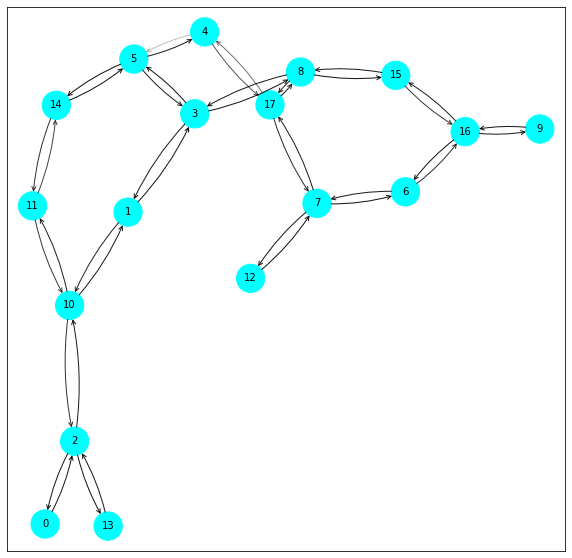

In [ ]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

# Visualize result
ax, G = explainer.visualize_subgraph(node_idx = None, edge_index = batch.edge_index, edge_mask = edge_mask, y=batch.y)
plt.show()

In [ ]:
batch = next(iter(g_loader))
# yhat = model(batch.x.float(), batch.edge_index, batch.batch)
print(batch.x.float().size())

torch.Size([40, 30])


In [ ]:
print(batch.smiles)

['[C@]34([C@H]([C@H]2C(F)([C@@]1(C(=CC(=O)C=C1)[C@@H](F)C2)C)[C@@H](O)C3)C[C@H]5O[C@H](O[C@@]45C(O[C@@H](OC(OCC)=O)C)=O)CCC)C']


In [ ]:
print("itrocinonide")

itrocinonide


In [ ]:
print(batch.y)

tensor([[1]])


In [ ]:
graph_feat_mask, edge_mask = explainer.explain_graph(batch.x.float(), batch.edge_index)

Explain graph: 100%|██████████| 200/200 [00:01<00:00, 173.78it/s]


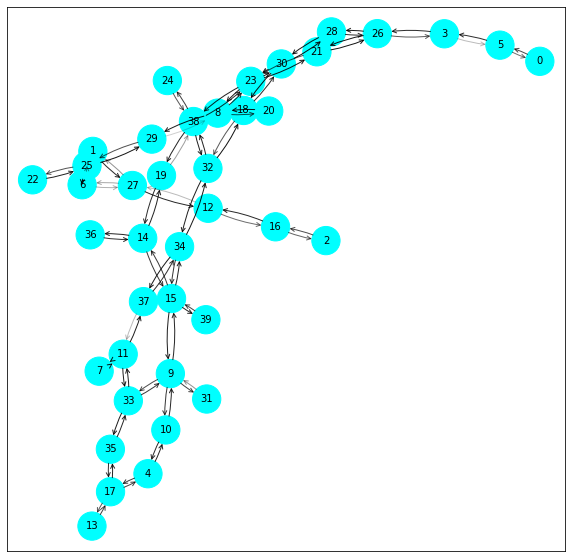

In [ ]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

# Visualize result
ax, G = explainer.visualize_subgraph(node_idx = None, edge_index = batch.edge_index, edge_mask = edge_mask, y=batch.y)
plt.show()

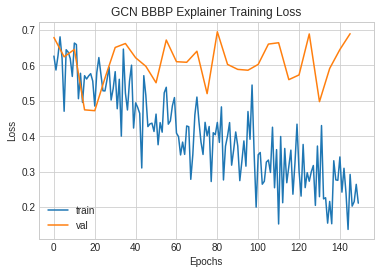

In [ ]:
import seaborn as sns
losses_float = [float(loss) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses)] 

losses_valid_float = [float(loss) for loss in losses_valid] 
loss_indices_valid = [i for i,l in enumerate(losses_valid)] 

loss_indices_valid = [x * 5 for x in loss_indices_valid]

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

plt.plot(loss_indices, losses_float, label='train');
plt.plot(loss_indices_valid, losses_valid_float, label='val')
plt.title("GCN BBBP Explainer Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show()

In [ ]:
import pandas as pd 

df = pd.DataFrame()
column_names = ["y_real", "y_pred"]
df = pd.DataFrame(columns = column_names)

for test_batch in test_loader:
  with torch.no_grad():
      test_batch.to(device)
      pred = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
      out = (pred>0.5).float()

      xtra = {"y_real": test_batch.y.tolist(),"y_pred": out.tolist()}
      df = df.append(pd.DataFrame(xtra))
      

      # df["y_real"] = test_batch.y.tolist()
      
      # df["y_pred"] = out.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0
...,...,...
72,1,1.0
73,0,1.0
74,1,1.0
75,1,1.0


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(df["y_real"], df["y_pred"])

0.9024390243902439

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df["y_real"], df["y_pred"])

0.8639861995753715

In [ ]:
from sklearn.metrics import f1_score
f1_score(df["y_real"], df["y_pred"])

0.9363057324840764

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

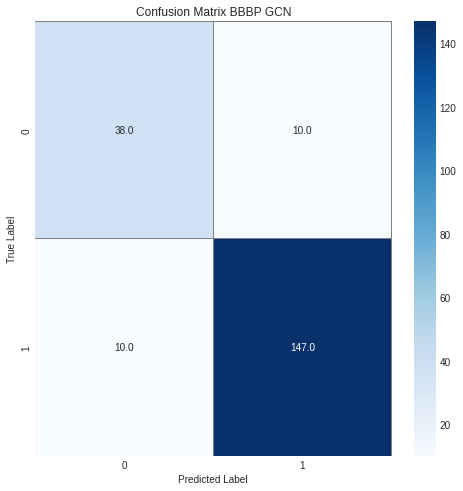

In [ ]:
cm = confusion_matrix(df["y_real"], df["y_pred"])

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.title("Confusion Matrix BBBP GCN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true=df["y_real"], y_pred=df["y_pred"], target_names=["0", "1"])
print(report)

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        48
           1       0.94      0.94      0.94       157

    accuracy                           0.90       205
   macro avg       0.86      0.86      0.86       205
weighted avg       0.90      0.90      0.90       205

